In [ ]:
# import libraries
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import pandas as pd
import os
from tqdm import tqdm

In [ ]:
# create the output directory if it does not exist. Remove all files from it if it exists (it would automatically be there when using Kaggle)
OUTPUT_ROOT = "/kaggle/working"
os.makedirs(OUTPUT_ROOT, exist_ok=True)
!rm -rf /kaggle/working/*

In [ ]:
# set the device type
if torch.cuda.is_available(): # if CUDA is available
    device = torch.device('cuda') # use the GPU
elif torch.backends.mps.is_available(): # if MPS is available
    device = torch.device('mps') # use the MPS
else: # otherwise
    device = torch.device('cpu') # use the CPU
print('Using device:', device) # print the device used

Using device: cuda


In [ ]:
# set the seeds for reproducibility
random.seed(420)
np.random.seed(420)
torch.manual_seed(420)
if torch.cuda.is_available():
    torch.cuda.manual_seed(420)

# Dataset
Let's create a CSV file for the dataset first because this dataset did not have a CSV file stating the file path and the labels. Having a CSV file will then help us in creating the custom dataset class. Please either run this notebook on Kaggle with this <a href="https://www.kaggle.com/datasets/unclesamulus/blood-cells-image-dataset">dataset</a> or download the dataset, create the ROOT and DATA_DIR directories mentioned below and add the 8 folders containing the images in DATA_DIR.

In [ ]:
# Specify the data directories to create the CSV file
ROOT = "/kaggle/input/blood-cells-image-dataset"
os.makedirs(ROOT, exist_ok=True)
DATA_DIR = os.path.join(ROOT, "bloodcells_dataset")
os.makedirs(DATA_DIR, exist_ok=True)
CSV_PATH = os.path.join(OUTPUT_ROOT, "bloodcells.csv")

if not os.path.exists(CSV_PATH): # if the CSV file does not exist
    data = [] # create a list to store the data
    for label in os.listdir(DATA_DIR): # for each label
        label_path = os.path.join(DATA_DIR, label) # get the path to the label
        if os.path.isdir(label_path): # if the path is a directory
            for img_file in os.listdir(label_path): # for each image file in the directory
                img_path = os.path.join(label_path, img_file) # get the path to the image
                data.append([img_path, label]) # add the image path and label to the data list
    # Save data to CSV
    df = pd.DataFrame(data, columns=["image_path", "label"]) # create a DataFrame from the data
    df.to_csv(CSV_PATH, index=False) # save the DataFrame to a CSV file
else: # do nothing if the CSV file already exists
    print("CSV already exists, skipping generation.") 

Now lets create the dataset class because based on different models, we would need different input sizes. These input sizes are set using tranform in PyTorch. For better flow, we can simply pass the model name to the custom dataset class so that it applies the size transformation based on that model.

In [ ]:
classes = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet'] # define the classes
num_classes = len(classes) # number of classes

class BloodCellsDataset(Dataset):
    '''
    class: A custom dataset class for the blood cells dataset
    '''
    def __init__(self, csv_file, transform=None):
        '''
        function: initializes the dataset
        parameters:
            csv_file (str): the path to the CSV file containing the image paths and labels
            transform (torchvision.transforms.Compose): the transformations to apply to the images
        returns: None
        '''
        self.data = pd.read_csv(csv_file) # read the CSV
        self.transform = transform # set the transformations

    def __len__(self):
        '''
        function: returns the length of the dataset
        parameters: None
        returns: int
        '''
        return len(self.data) # return the length of the dataset

    def __getitem__(self, idx):
        '''
        function: returns an item from the dataset
        parameters: 
            idx (int): the index of the item to return
        returns: tuple
        '''
        img_path = self.data.iloc[idx, 0] # get the image path
        label = self.data.iloc[idx, 1] # get the label
        label_idx = classes.index(label) # get the index of the label
        image = Image.open(img_path).convert("RGB") # open the image
        if self.transform: # if transformations are provided
            image = self.transform(image) # apply the transformations
        return image, label_idx # return the image and label index

# Visualisation  



Let's visualise one image from each class and also see what the transformations that were selected are doing.

In [ ]:
def show_image(img, title = ""):
    '''
    function: Plot/show image
    parameters:
        img (torch.Tensor): Image
        title (str): Title of the image
    returns: None
    '''
    if isinstance(img, Image.Image): # if the image is a PIL image
        img = transforms.ToTensor()(img) # convert the image to a tensor
    npimg = img.numpy() # convert image tensor to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # switch channels from (C, H, W) to (H, W, C) (based on matplotlib configuration)
    plt.title(title) # set the title
    plt.show() # show the image

def show_images_per_class(dataset, classes):
    '''
    function: Show images per class
    parameters:
        dataset (Dataset): Dataset
        classes (List[str]): List of classes
    returns: None
    '''
    images_seen = set() # set to store the images seen
    indices = list(range(len(dataset))) # get the indices of the dataset
    random.shuffle(indices) # shuffle the indices (higher chance to see all the images in the dataset quickly)
    
    for idx in indices: # for each index
        img, label = dataset[idx] # get the image and label
        class_name = classes[label] # get the class name
        if class_name not in images_seen: # if the class has not been seen
            show_image(img, title=f"Class: {class_name}") # show the image
            images_seen.add(class_name) # add the class to the set of images seen
        if len(images_seen) == len(classes): # if all classes have been seen, break out of the loop
            break

In [ ]:
MEAN = (0.5, 0.5, 0.5) # mean for normalization (dataset mean was not available)
STD = (0.5, 0.5, 0.5) # standard deviation for normalization (dataset standard deviation was not available)

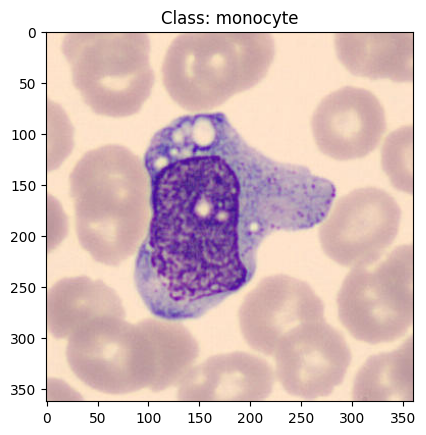

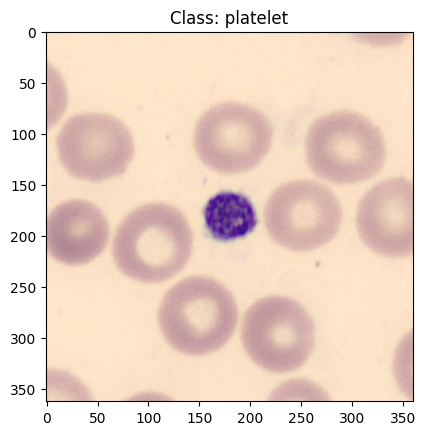

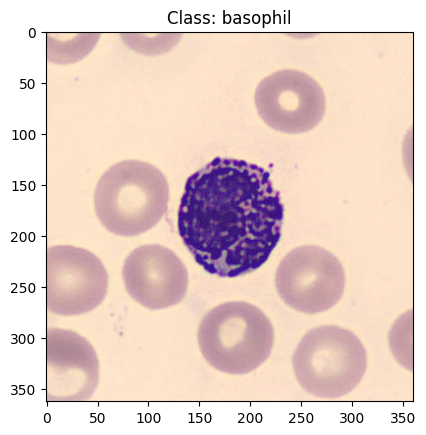

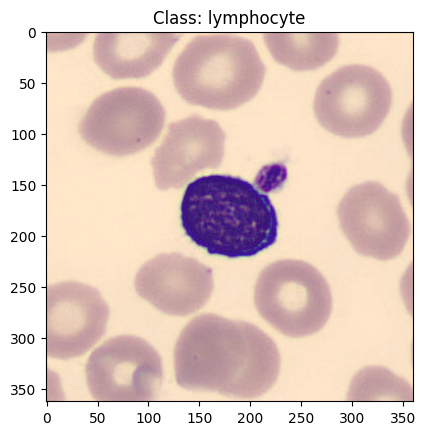

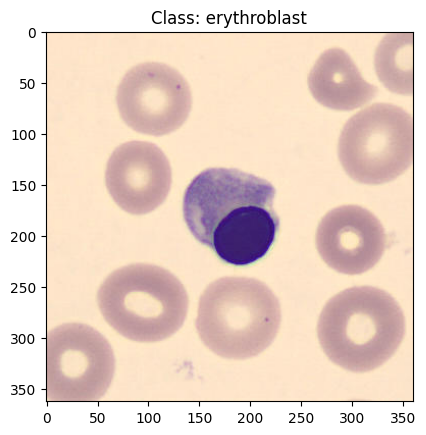

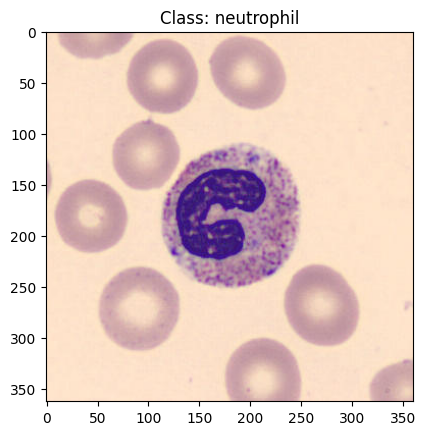

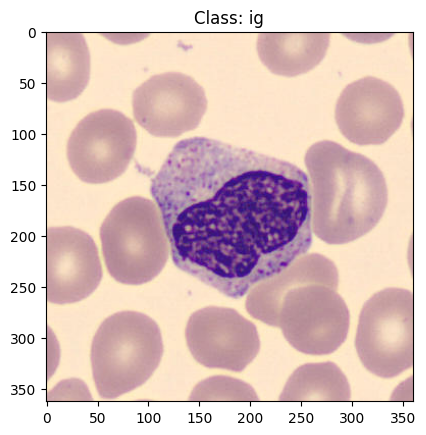

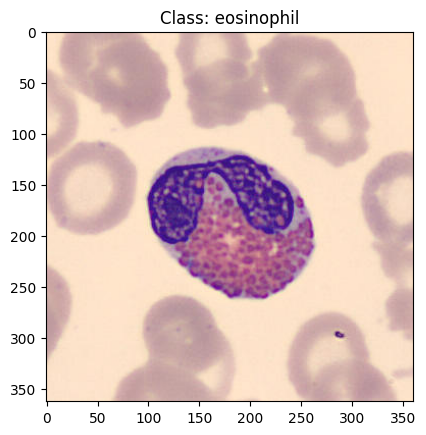

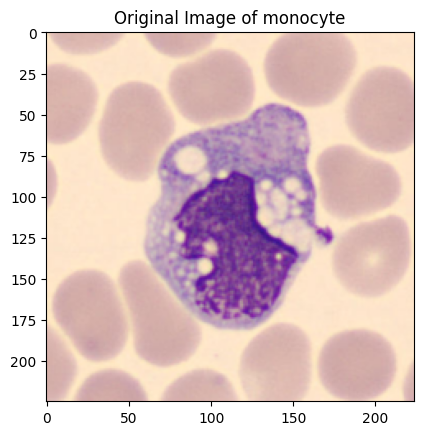

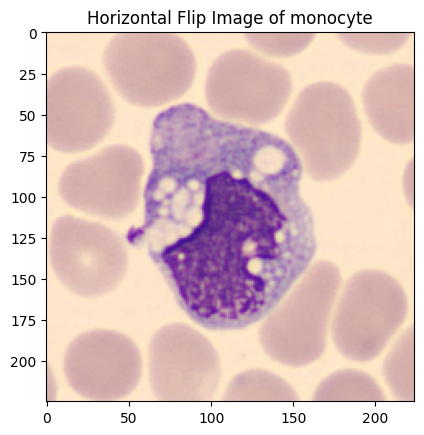

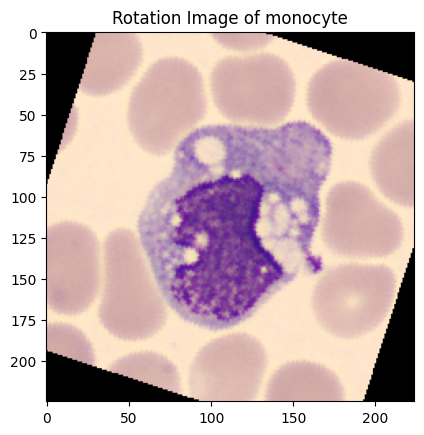

In [ ]:
dataset = BloodCellsDataset(CSV_PATH) # dataset for visualisation
show_images_per_class(dataset, classes) # use the function to show one image of each class

transformations = {
    "Original": transforms.Compose([transforms.Resize(224), transforms.ToTensor()]),
    "Horizontal Flip": transforms.Compose([transforms.Resize(224), transforms.RandomHorizontalFlip(1), transforms.ToTensor()]),
    "Rotation": transforms.Compose([transforms.Resize(224), transforms.RandomRotation(30), transforms.ToTensor()])
} # transformations to apply to the images (for visualisation)

for img, label in dataset: # Loop through the dataset
    for name, transform in transformations.items(): # for each transformation
        transformed_img = transform(img) # Apply each transform on the PIL image
        show_image(transformed_img, title=f"{name} Image of {classes[label]}") # Show the transformed image
    break # break because we just want to show what each transformation does on one image

# Modelling

In [ ]:
class CustomCNN(nn.Module):
    '''
    class: A custom CNN class
    '''
    def __init__(self, num_classes=1000):
        '''
        function: initializes the CNN
        parameters:
            num_classes (int): the number of classes
        returns: None
        '''
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # 224x224x3 -> 224x224x64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112x112x64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # 112x112x64 -> 112x112x128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56x56x128

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # 56x56x128 -> 56x56x256
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28x28x256

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # 28x28x256 -> 28x28x512
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14x512
            nn.Dropout(0.4)
        ) # convolutional layers (convolution + ReLU + max-pooling + dropout)
        # output dims were calculated using the formula: (W + 2P - F)/S + 1, D = K

        self.classifier = nn.Sequential(
            nn.Flatten(), # flatten output
            nn.Linear(512 * 14 * 14, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes) # output layer
        )

    def forward(self, x):
        '''
        function: forward pass
        parameters:
            x (torch.Tensor): input tensor
        returns: torch.Tensor
        '''
        x = self.features(x)
        x = self.classifier(x)
        return x

Learning rate was decided by testing for different values using the following code block, keeping the optimising variable True. Once that was done, optimising was turned to False and the code was run.

In [ ]:
# create figures and results directory
figure_dir = os.path.join(OUTPUT_ROOT, "figures")
results_dir = os.path.join(OUTPUT_ROOT, "results")
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# define the models
all_models = {
    "CustomCNN": CustomCNN(num_classes=num_classes),
    "AlexNet": models.alexnet(weights=None, num_classes=num_classes),
    "VGG-13": models.vgg13(weights=None, num_classes=num_classes),
    "InceptionNet": models.inception_v3(weights=None, num_classes=num_classes, aux_logits=False),
    "ResNet-18": models.resnet18(weights=None, num_classes=num_classes)
}
model_names = list(all_models.keys())

# initialize results DataFrame and validation loss dictionaries
results_csv_path = os.path.join(results_dir, "results.csv")
losses_csv_path = os.path.join(results_dir, "validation_losses.csv")

# initialize DataFrame for first model’s losses if optimizing
optimising = False

print("Using device: ", device) # print the device used
# empty cache if a device is being used
if device == "mps":
    torch.backends.mps.empty_cache()
elif device == "cuda":
    torch.cuda.empty_cache()

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
]) # train transform

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
]) # test transform

for model_name, model in all_models.items():
    # create datasets and loaders
    dataset = BloodCellsDataset(csv_file=CSV_PATH, transform=None) # create the dataset
    all_labels = [classes.index(label) for label in dataset.data["label"]] # get the labels
    
    # stratified split
    train_indices, valtest_indices, train_labels, valtest_labels = train_test_split(
        range(len(dataset)), all_labels, test_size=0.3, stratify=all_labels, random_state=42
    )
    val_indices, test_indices, _, _ = train_test_split(
        valtest_indices, valtest_labels, test_size=1/2, stratify=valtest_labels, random_state=42
    )

    # subsets and transforms
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    if model_name == "InceptionNet": # need to change the transforms input size for InceptionNet
        train_transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD),
        ])
        
        test_transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD),
        ])
    
    # assign the transforms
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = test_transform
    test_dataset.dataset.transform = test_transform

    # define the batch size and dataloaders
    batch_size = 32
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    num_epochs = 50 if optimising else 100 # number of epochs
    patience = 50 if optimising else 10 # Early stopping patience
    
    print(f"Training {model_name}...")
    model = model.to(device) # move the model to the device
    model_losses = []  # store validation losses for this model
    
    lr = 1e-5 # learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # adam optimizer
    criterion = nn.CrossEntropyLoss() # cross-entropy loss

    train_losses, val_losses = [], [] # store training and validation losses
    best_val_loss = float("inf") # best validation loss
    patience_counter = 0 # patience counter

    # create csv files if they do not exist, read if they exist
    if os.path.exists(results_csv_path): 
        results_df = pd.read_csv(results_csv_path) 
    else: 
        results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUROC"])
    
    if os.path.exists(losses_csv_path): 
        all_losses = pd.read_csv(losses_csv_path)
    else:
        all_losses = pd.DataFrame({"Epoch": range(1, num_epochs + 1)})
    
    if optimising: # create csv files for first model's (AlexNet's) losses if optimizing
        first_model_losses_csv_path = os.path.join(results_dir, f"AlexNet_losses_lr_{lr}.csv")
        first_model_losses = pd.DataFrame(columns=["Epoch", "Training Loss", "Validation Loss"])

    for epoch in tqdm(range(num_epochs)): # for each epoch
        model.train()  # set model to training mode
        running_loss = 0.0 # running loss

        for inputs, labels in trainloader: # for each batch
            inputs, labels = inputs.to(device), labels.to(device) # move inputs and labels to the device
            optimizer.zero_grad() # zero the parameter gradients
            outputs = model(inputs) # forward pass
            loss = criterion(outputs, labels) # calculate the loss
            loss.backward() # backward pass
            optimizer.step() # optimize the model
            running_loss += loss.item() # add the loss to the running loss
        
        avg_train_loss = running_loss / len(trainloader) # average training loss
        train_losses.append(avg_train_loss) # store the training loss

        model.eval() # set model to evaluation mode
        val_loss = 0.0 # validation loss
        with torch.no_grad(): # no gradients
            for inputs, labels in valloader: # for each batch
                inputs, labels = inputs.to(device), labels.to(device) # move inputs and labels to the device
                outputs = model(inputs) # forward pass
                loss = criterion(outputs, labels) # calculate the loss
                val_loss += loss.item() # add the loss to the validation loss
                
        avg_val_loss = val_loss / len(valloader) # average validation loss
        val_losses.append(avg_val_loss) # store the validation loss

        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

        if avg_val_loss < best_val_loss: # if the validation loss is the best
            best_val_loss = avg_val_loss # update the best validation loss
            patience_counter = 0 # reset the patience counter
        else: # otherwise
            patience_counter += 1 # increment the patience counter
            if patience_counter >= patience: # if the patience counter is greater than or equal to the patience
                print(f"Early stopping for {model_name} at epoch {epoch + 1}") # print early stopping message
                # Fill remaining epochs with the last recorded validation loss
                val_losses.extend([avg_val_loss] * (num_epochs - len(val_losses))) # fill the remaining epochs with the last recorded loss for plotting
                train_losses.extend([avg_train_loss] * (num_epochs - len(train_losses))) # fill the remaining epochs with the last recorded loss for plotting
                break # break out of the loop

        # store first model's (AlexNet's) losses when optimizing
        if optimising:
            if epoch == 0:
                first_model_losses["Epoch"] = range(1, num_epochs + 1)
            first_model_losses = pd.concat([
                first_model_losses,
                pd.DataFrame({
                    "Epoch": [epoch + 1],
                    "Training Loss": [avg_train_loss],
                    "Validation Loss": [avg_val_loss]
                })
            ], ignore_index=True)
            first_model_losses.to_csv(first_model_losses_csv_path, index=False)

    # save model losses up to num_epochs with padded values for early stopping
    all_losses.loc[:len(train_losses) - 1, f"{model_name}_Train_Loss"] = train_losses
    all_losses.loc[:len(val_losses) - 1, f"{model_name}_Val_Loss"] = val_losses
    all_losses.to_csv(losses_csv_path, index=False)
    
    # plotting the first model's (AlexNet's) losses and stopping if optimising
    if optimising:
        plt.plot(first_model_losses["Epoch"], first_model_losses["Training Loss"], label="Training Loss")
        plt.plot(first_model_losses["Epoch"], first_model_losses["Validation Loss"], label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"{model_name} Losses (Learning Rate: {lr})")
        plt.legend()
        plt.savefig(os.path.join(figure_dir, f"{model_name}_train_val_loss_lr_{lr}.png"))
        plt.close()
        break

    if not optimising: # if not optimizing
        model.eval() # set model to evaluation mode
        test_labels, test_preds, test_probs = [], [], [] # store test labels, predictions, and probabilities
        with torch.no_grad(): # no gradients
            for inputs, labels in testloader: # for each batch
                inputs, labels = inputs.to(device), labels.to(device) # move inputs and labels to the device
                outputs = model(inputs) # forward pass
                _, predicted = torch.max(outputs, 1) # get the predicted labels
                probabilities = nn.Softmax(dim=1)(outputs) # 
                test_labels.extend(labels.cpu().numpy()) # store the test labels
                test_preds.extend(predicted.cpu().numpy()) # store the test predictions
                test_probs.extend(probabilities.cpu().numpy()) # store the test probabilities

        # Calculate and store metrics
        accuracy = accuracy_score(test_labels, test_preds)
        precision = precision_score(test_labels, test_preds, average="macro")
        recall = recall_score(test_labels, test_preds, average="macro")
        f1 = f1_score(test_labels, test_preds, average="macro")
        auroc = roc_auc_score(np.array(test_labels), np.array(test_probs), multi_class="ovr")

        new_df = pd.DataFrame({
            "Model": [model_name],
            "Accuracy": [accuracy],
            "Precision": [precision],
            "Recall": [recall],
            "F1 Score": [f1],
            "AUROC": [auroc]
        }) # create a DataFrame for the results
        results_df = pd.concat([results_df, new_df], ignore_index=True) # concatenate the new results to the existing results
        results_df.to_csv(results_csv_path, index=False) # save the results to a CSV file

# Plot all model validation losses when not optimizing
if not optimising:
    for model_name in all_models.keys():
        if f"{model_name}_Val_Loss" in all_losses.columns:
            plt.plot(all_losses["Epoch"], all_losses[f"{model_name}_Val_Loss"], label=model_name)

    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.savefig(os.path.join(figure_dir, "validation_loss_all_models.png"))
    plt.close()

/opt/conda/lib/python3.10/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Using device:  cuda
Training CustomCNN...


  1%|          | 1/100 [00:57<1:34:51, 57.49s/it]

Epoch [1/100], Training Loss: 1.4069271905218217, Validation Loss: 0.9968812495102117


  2%|▏         | 2/100 [01:51<1:30:50, 55.62s/it]

Epoch [2/100], Training Loss: 0.8887239115282813, Validation Loss: 0.7390600564303221


  3%|▎         | 3/100 [02:46<1:28:53, 54.99s/it]

Epoch [3/100], Training Loss: 0.7024729099662547, Validation Loss: 0.6176673850895446


  4%|▍         | 4/100 [03:40<1:27:44, 54.84s/it]

Epoch [4/100], Training Loss: 0.5670186340569813, Validation Loss: 0.5182854238851571


  5%|▌         | 5/100 [04:34<1:26:29, 54.63s/it]

Epoch [5/100], Training Loss: 0.46895263304206775, Validation Loss: 0.4431011818441344


  6%|▌         | 6/100 [05:29<1:25:20, 54.47s/it]

Epoch [6/100], Training Loss: 0.398659921186493, Validation Loss: 0.394714809678219


  7%|▋         | 7/100 [06:23<1:24:19, 54.40s/it]

Epoch [7/100], Training Loss: 0.3499279643762558, Validation Loss: 0.35504202563085674


  8%|▊         | 8/100 [07:17<1:23:19, 54.35s/it]

Epoch [8/100], Training Loss: 0.31929398810162263, Validation Loss: 0.34616095333555597


  9%|▉         | 9/100 [08:11<1:22:12, 54.21s/it]

Epoch [9/100], Training Loss: 0.29396467877023996, Validation Loss: 0.33640201169031636


 10%|█         | 10/100 [09:05<1:21:20, 54.23s/it]

Epoch [10/100], Training Loss: 0.2723974472877973, Validation Loss: 0.3006399898433391


 11%|█         | 11/100 [09:59<1:20:22, 54.18s/it]

Epoch [11/100], Training Loss: 0.2545836578337426, Validation Loss: 0.2911393133762442


 12%|█▏        | 12/100 [10:54<1:19:28, 54.19s/it]

Epoch [12/100], Training Loss: 0.2327528885281819, Validation Loss: 0.27790892988811305


 13%|█▎        | 13/100 [11:48<1:18:34, 54.19s/it]

Epoch [13/100], Training Loss: 0.2193485301256897, Validation Loss: 0.2697503478438766


 14%|█▍        | 14/100 [12:42<1:17:48, 54.29s/it]

Epoch [14/100], Training Loss: 0.20892184682907586, Validation Loss: 0.27632921607590016


 15%|█▌        | 15/100 [13:37<1:16:54, 54.29s/it]

Epoch [15/100], Training Loss: 0.19998712778928127, Validation Loss: 0.2900079623048688


 16%|█▌        | 16/100 [14:31<1:15:57, 54.25s/it]

Epoch [16/100], Training Loss: 0.18811720288433334, Validation Loss: 0.24495201433698335


 17%|█▋        | 17/100 [15:25<1:15:12, 54.37s/it]

Epoch [17/100], Training Loss: 0.1755703181192717, Validation Loss: 0.2333995070722368


 18%|█▊        | 18/100 [16:19<1:14:06, 54.22s/it]

Epoch [18/100], Training Loss: 0.16504372355035124, Validation Loss: 0.24363045711760167


 19%|█▉        | 19/100 [17:13<1:13:04, 54.13s/it]

Epoch [19/100], Training Loss: 0.16171357675111867, Validation Loss: 0.2312340965885439


 20%|██        | 20/100 [18:07<1:12:02, 54.03s/it]

Epoch [20/100], Training Loss: 0.15271721498911234, Validation Loss: 0.21926874892763148


 21%|██        | 21/100 [19:01<1:11:00, 53.93s/it]

Epoch [21/100], Training Loss: 0.1421577150878661, Validation Loss: 0.25216274922368703


 22%|██▏       | 22/100 [19:54<1:10:04, 53.91s/it]

Epoch [22/100], Training Loss: 0.13775423113605317, Validation Loss: 0.22853768492738405


 23%|██▎       | 23/100 [20:48<1:09:09, 53.89s/it]

Epoch [23/100], Training Loss: 0.13314418150311247, Validation Loss: 0.22293654810867192


 24%|██▍       | 24/100 [21:43<1:08:25, 54.02s/it]

Epoch [24/100], Training Loss: 0.12447911874953917, Validation Loss: 0.2176113717120003


 25%|██▌       | 25/100 [22:37<1:07:39, 54.13s/it]

Epoch [25/100], Training Loss: 0.1172821700104816, Validation Loss: 0.22303233709600237


 26%|██▌       | 26/100 [23:31<1:06:48, 54.17s/it]

Epoch [26/100], Training Loss: 0.11667116434328298, Validation Loss: 0.21926786628678258


 27%|██▋       | 27/100 [24:26<1:06:08, 54.37s/it]

Epoch [27/100], Training Loss: 0.11019673198212517, Validation Loss: 0.21625858073893153


 28%|██▊       | 28/100 [25:20<1:05:11, 54.33s/it]

Epoch [28/100], Training Loss: 0.10332069035001935, Validation Loss: 0.22928107718442692


 29%|██▉       | 29/100 [26:15<1:04:19, 54.36s/it]

Epoch [29/100], Training Loss: 0.10080381389458311, Validation Loss: 0.21700154748503808


 30%|███       | 30/100 [27:10<1:03:36, 54.52s/it]

Epoch [30/100], Training Loss: 0.0922253428059406, Validation Loss: 0.2027933324146786


 31%|███       | 31/100 [28:04<1:02:37, 54.46s/it]

Epoch [31/100], Training Loss: 0.08860171061845865, Validation Loss: 0.21087925761570164


 32%|███▏      | 32/100 [28:58<1:01:35, 54.35s/it]

Epoch [32/100], Training Loss: 0.08606418330013194, Validation Loss: 0.2041037577767799


 33%|███▎      | 33/100 [29:52<1:00:38, 54.30s/it]

Epoch [33/100], Training Loss: 0.07716191397546567, Validation Loss: 0.20685276646672943


 34%|███▍      | 34/100 [30:47<59:44, 54.31s/it]  

Epoch [34/100], Training Loss: 0.07625907424334337, Validation Loss: 0.23218658430800762


 35%|███▌      | 35/100 [31:41<58:46, 54.25s/it]

Epoch [35/100], Training Loss: 0.0737725921625142, Validation Loss: 0.23166952390269732


 36%|███▌      | 36/100 [32:35<57:48, 54.20s/it]

Epoch [36/100], Training Loss: 0.06784736600649707, Validation Loss: 0.2048711344760693


 37%|███▋      | 37/100 [33:29<56:50, 54.14s/it]

Epoch [37/100], Training Loss: 0.06561145299975885, Validation Loss: 0.20523379938561975


 38%|███▊      | 38/100 [34:23<55:57, 54.15s/it]

Epoch [38/100], Training Loss: 0.060623079942997524, Validation Loss: 0.2288212986823953


 39%|███▉      | 39/100 [35:17<54:59, 54.09s/it]

Epoch [39/100], Training Loss: 0.062011180241358155, Validation Loss: 0.21172886879907715


 39%|███▉      | 39/100 [36:12<56:37, 55.70s/it]

Epoch [40/100], Training Loss: 0.0555313116489358, Validation Loss: 0.23370812427436496
Early stopping for CustomCNN at epoch 40



/tmp/ipykernel_23/3891940670.py:218: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_df], ignore_index=True)


Training AlexNet...


  1%|          | 1/100 [00:31<51:19, 31.10s/it]

Epoch [1/100], Training Loss: 1.695083316634683, Validation Loss: 1.3174940951076555


  2%|▏         | 2/100 [01:01<50:21, 30.83s/it]

Epoch [2/100], Training Loss: 1.22105570081721, Validation Loss: 1.1188760179060477


  3%|▎         | 3/100 [01:32<49:37, 30.69s/it]

Epoch [3/100], Training Loss: 0.8636571269303082, Validation Loss: 0.7425606394255603


  4%|▍         | 4/100 [02:03<49:37, 31.02s/it]

Epoch [4/100], Training Loss: 0.6785994690847906, Validation Loss: 0.6050994017241914


  5%|▌         | 5/100 [02:34<48:56, 30.91s/it]

Epoch [5/100], Training Loss: 0.6144550571785891, Validation Loss: 0.5623545830632434


  6%|▌         | 6/100 [03:05<48:32, 30.98s/it]

Epoch [6/100], Training Loss: 0.5655032782392069, Validation Loss: 0.5721880142335538


  7%|▋         | 7/100 [03:35<47:39, 30.75s/it]

Epoch [7/100], Training Loss: 0.5182202960797809, Validation Loss: 0.550292604315428


  8%|▊         | 8/100 [04:06<46:56, 30.61s/it]

Epoch [8/100], Training Loss: 0.46945190357970684, Validation Loss: 0.4452732843749317


  9%|▉         | 9/100 [04:35<45:54, 30.27s/it]

Epoch [9/100], Training Loss: 0.42303942267429384, Validation Loss: 0.4133771599074941


 10%|█         | 10/100 [05:06<45:46, 30.52s/it]

Epoch [10/100], Training Loss: 0.38525277665034335, Validation Loss: 0.38299677383016656


 11%|█         | 11/100 [05:38<45:40, 30.79s/it]

Epoch [11/100], Training Loss: 0.3628148805290301, Validation Loss: 0.38618602962405596


 12%|█▏        | 12/100 [06:09<45:28, 31.01s/it]

Epoch [12/100], Training Loss: 0.33643078909599206, Validation Loss: 0.32968234142035613


 13%|█▎        | 13/100 [06:39<44:24, 30.63s/it]

Epoch [13/100], Training Loss: 0.31846128730850426, Validation Loss: 0.3115868213368051


 14%|█▍        | 14/100 [07:10<44:05, 30.77s/it]

Epoch [14/100], Training Loss: 0.2936839731858376, Validation Loss: 0.2950913985202342


 15%|█▌        | 15/100 [07:41<43:35, 30.77s/it]

Epoch [15/100], Training Loss: 0.2811885273213533, Validation Loss: 0.2768205835679431


 16%|█▌        | 16/100 [08:12<43:22, 30.98s/it]

Epoch [16/100], Training Loss: 0.27327950194199135, Validation Loss: 0.30086406973409063


 17%|█▋        | 17/100 [08:43<42:42, 30.87s/it]

Epoch [17/100], Training Loss: 0.2630317786828002, Validation Loss: 0.2702523856251328


 18%|█▊        | 18/100 [09:13<42:00, 30.73s/it]

Epoch [18/100], Training Loss: 0.2381754365953851, Validation Loss: 0.24349958504791613


 19%|█▉        | 19/100 [09:44<41:21, 30.64s/it]

Epoch [19/100], Training Loss: 0.23630159819887125, Validation Loss: 0.3855322441201151


 20%|██        | 20/100 [10:14<40:43, 30.54s/it]

Epoch [20/100], Training Loss: 0.22706205351527203, Validation Loss: 0.2504933865993847


 21%|██        | 21/100 [10:44<39:52, 30.28s/it]

Epoch [21/100], Training Loss: 0.2208355266182499, Validation Loss: 0.2923037903268396


 22%|██▏       | 22/100 [11:14<39:19, 30.24s/it]

Epoch [22/100], Training Loss: 0.20719931608832934, Validation Loss: 0.27593734294727995


 23%|██▎       | 23/100 [11:44<38:43, 30.18s/it]

Epoch [23/100], Training Loss: 0.20867963240825557, Validation Loss: 0.2286625446314797


 24%|██▍       | 24/100 [12:14<38:19, 30.26s/it]

Epoch [24/100], Training Loss: 0.19847783648015502, Validation Loss: 0.22614907445730986


 25%|██▌       | 25/100 [12:45<37:55, 30.34s/it]

Epoch [25/100], Training Loss: 0.1903065790068657, Validation Loss: 0.21723244937113773


 26%|██▌       | 26/100 [13:16<37:48, 30.66s/it]

Epoch [26/100], Training Loss: 0.18067548437950445, Validation Loss: 0.22963673554728797


 27%|██▋       | 27/100 [13:47<37:12, 30.58s/it]

Epoch [27/100], Training Loss: 0.17563064722095262, Validation Loss: 0.2567985230297954


 28%|██▊       | 28/100 [14:17<36:40, 30.56s/it]

Epoch [28/100], Training Loss: 0.17921761634017536, Validation Loss: 0.24113657684237869


 29%|██▉       | 29/100 [14:47<35:54, 30.34s/it]

Epoch [29/100], Training Loss: 0.1687055533716983, Validation Loss: 0.20743787838261069


 30%|███       | 30/100 [15:17<35:19, 30.28s/it]

Epoch [30/100], Training Loss: 0.1733121577062629, Validation Loss: 0.1927057962036795


 31%|███       | 31/100 [15:47<34:44, 30.21s/it]

Epoch [31/100], Training Loss: 0.15924967264378054, Validation Loss: 0.19644653854638705


 32%|███▏      | 32/100 [16:18<34:15, 30.23s/it]

Epoch [32/100], Training Loss: 0.15787062263564472, Validation Loss: 0.2086110472633147


 33%|███▎      | 33/100 [16:47<33:38, 30.13s/it]

Epoch [33/100], Training Loss: 0.14962982104712708, Validation Loss: 0.19165247515487818


 34%|███▍      | 34/100 [17:18<33:17, 30.27s/it]

Epoch [34/100], Training Loss: 0.15253627378453705, Validation Loss: 0.19121371586749583


 35%|███▌      | 35/100 [17:48<32:47, 30.28s/it]

Epoch [35/100], Training Loss: 0.14448063718005616, Validation Loss: 0.19592573038405842


 36%|███▌      | 36/100 [18:18<32:15, 30.24s/it]

Epoch [36/100], Training Loss: 0.13720281806122014, Validation Loss: 0.20966561090339114


 37%|███▋      | 37/100 [18:48<31:34, 30.07s/it]

Epoch [37/100], Training Loss: 0.13141148633517843, Validation Loss: 0.16606626638935673


 38%|███▊      | 38/100 [19:19<31:14, 30.23s/it]

Epoch [38/100], Training Loss: 0.1298045616828523, Validation Loss: 0.16704195441195258


 39%|███▉      | 39/100 [19:49<30:41, 30.18s/it]

Epoch [39/100], Training Loss: 0.12978675431462333, Validation Loss: 0.18441919676591584


 40%|████      | 40/100 [20:19<30:07, 30.13s/it]

Epoch [40/100], Training Loss: 0.1229894646582876, Validation Loss: 0.16581045187733792


 41%|████      | 41/100 [20:49<29:31, 30.03s/it]

Epoch [41/100], Training Loss: 0.1130655484204305, Validation Loss: 0.16038143947536562


 42%|████▏     | 42/100 [21:19<29:09, 30.17s/it]

Epoch [42/100], Training Loss: 0.12188218114524084, Validation Loss: 0.17747759269435465


 43%|████▎     | 43/100 [21:50<28:44, 30.26s/it]

Epoch [43/100], Training Loss: 0.1080873662090417, Validation Loss: 0.17823596888532242


 44%|████▍     | 44/100 [22:19<28:02, 30.05s/it]

Epoch [44/100], Training Loss: 0.10995599395535727, Validation Loss: 0.1659434433842515


 45%|████▌     | 45/100 [22:49<27:33, 30.06s/it]

Epoch [45/100], Training Loss: 0.10642267374899538, Validation Loss: 0.1830923634086862


 46%|████▌     | 46/100 [23:20<27:08, 30.16s/it]

Epoch [46/100], Training Loss: 0.10148112080059946, Validation Loss: 0.15635150447947743


 47%|████▋     | 47/100 [23:49<26:34, 30.08s/it]

Epoch [47/100], Training Loss: 0.09743691301770149, Validation Loss: 0.17067772930740943


 48%|████▊     | 48/100 [24:20<26:08, 30.15s/it]

Epoch [48/100], Training Loss: 0.09359642814902121, Validation Loss: 0.16885477589029405


 49%|████▉     | 49/100 [24:50<25:32, 30.05s/it]

Epoch [49/100], Training Loss: 0.09644383305738516, Validation Loss: 0.17145653439823677


 50%|█████     | 50/100 [25:20<25:05, 30.12s/it]

Epoch [50/100], Training Loss: 0.09232692305436906, Validation Loss: 0.14663395598921694


 51%|█████     | 51/100 [25:51<24:43, 30.28s/it]

Epoch [51/100], Training Loss: 0.08750675388059036, Validation Loss: 0.16835519329955181


 52%|█████▏    | 52/100 [26:20<24:07, 30.16s/it]

Epoch [52/100], Training Loss: 0.08957200658066886, Validation Loss: 0.18846801164801474


 53%|█████▎    | 53/100 [26:51<23:41, 30.25s/it]

Epoch [53/100], Training Loss: 0.08252528874716537, Validation Loss: 0.14520677102062804


 54%|█████▍    | 54/100 [27:21<23:09, 30.20s/it]

Epoch [54/100], Training Loss: 0.08153490998728057, Validation Loss: 0.16362467280554552


 55%|█████▌    | 55/100 [27:51<22:37, 30.17s/it]

Epoch [55/100], Training Loss: 0.07645855639889378, Validation Loss: 0.16357696056365967


 56%|█████▌    | 56/100 [28:21<21:57, 29.95s/it]

Epoch [56/100], Training Loss: 0.07742580014684382, Validation Loss: 0.14620500053049146


 57%|█████▋    | 57/100 [28:50<21:21, 29.80s/it]

Epoch [57/100], Training Loss: 0.07050690914779394, Validation Loss: 0.19035716985501808


 58%|█████▊    | 58/100 [29:19<20:40, 29.53s/it]

Epoch [58/100], Training Loss: 0.06518936319336455, Validation Loss: 0.15359382546955236


 59%|█████▉    | 59/100 [29:48<20:09, 29.51s/it]

Epoch [59/100], Training Loss: 0.07837879857643543, Validation Loss: 0.18482866211805815


 60%|██████    | 60/100 [30:18<19:40, 29.51s/it]

Epoch [60/100], Training Loss: 0.06268865630910907, Validation Loss: 0.15548695115096592


 61%|██████    | 61/100 [30:48<19:13, 29.58s/it]

Epoch [61/100], Training Loss: 0.06097296145567197, Validation Loss: 0.1562961573643541


 62%|██████▏   | 62/100 [31:17<18:43, 29.57s/it]

Epoch [62/100], Training Loss: 0.06550996830652064, Validation Loss: 0.15653039871738006


 62%|██████▏   | 62/100 [31:46<19:28, 30.76s/it]

Epoch [63/100], Training Loss: 0.057878870948436946, Validation Loss: 0.14841426774732952
Early stopping for AlexNet at epoch 63


Training VGG-13...


  1%|          | 1/100 [01:29<2:27:24, 89.34s/it]

Epoch [1/100], Training Loss: 1.4778170740221912, Validation Loss: 0.9298681160550059


  2%|▏         | 2/100 [02:58<2:26:00, 89.39s/it]

Epoch [2/100], Training Loss: 0.6989559488978615, Validation Loss: 0.4547529204024209


  3%|▎         | 3/100 [04:28<2:24:49, 89.59s/it]

Epoch [3/100], Training Loss: 0.44444272804626805, Validation Loss: 0.36750077814967547


  4%|▍         | 4/100 [05:58<2:23:17, 89.55s/it]

Epoch [4/100], Training Loss: 0.34017175360318813, Validation Loss: 0.2737822833436507


  5%|▌         | 5/100 [07:27<2:21:36, 89.44s/it]

Epoch [5/100], Training Loss: 0.2962297142787094, Validation Loss: 0.25276504705349606


  6%|▌         | 6/100 [08:56<2:19:59, 89.35s/it]

Epoch [6/100], Training Loss: 0.24815671496531544, Validation Loss: 0.24844335180557806


  7%|▋         | 7/100 [10:25<2:18:25, 89.30s/it]

Epoch [7/100], Training Loss: 0.22468420223676586, Validation Loss: 0.20111695253922615


  8%|▊         | 8/100 [11:54<2:16:50, 89.25s/it]

Epoch [8/100], Training Loss: 0.2020039313378181, Validation Loss: 0.19073807268782897


  9%|▉         | 9/100 [13:24<2:15:20, 89.24s/it]

Epoch [9/100], Training Loss: 0.18204441944505761, Validation Loss: 0.2352791895377047


 10%|█         | 10/100 [14:52<2:13:43, 89.15s/it]

Epoch [10/100], Training Loss: 0.1652772804662426, Validation Loss: 0.18466042793919274


 11%|█         | 11/100 [16:21<2:12:08, 89.08s/it]

Epoch [11/100], Training Loss: 0.15340002347032894, Validation Loss: 0.19782863605629514


 12%|█▏        | 12/100 [17:50<2:10:34, 89.03s/it]

Epoch [12/100], Training Loss: 0.12697309442113508, Validation Loss: 0.16924409376296365


 13%|█▎        | 13/100 [19:19<2:09:04, 89.02s/it]

Epoch [13/100], Training Loss: 0.13034862192238078, Validation Loss: 0.16837087953693153


 14%|█▍        | 14/100 [20:48<2:07:38, 89.05s/it]

Epoch [14/100], Training Loss: 0.11227561810980227, Validation Loss: 0.15532748178969838


 15%|█▌        | 15/100 [22:17<2:06:06, 89.02s/it]

Epoch [15/100], Training Loss: 0.10598087178314114, Validation Loss: 0.17152123344073325


 16%|█▌        | 16/100 [23:46<2:04:35, 89.00s/it]

Epoch [16/100], Training Loss: 0.09828722133518465, Validation Loss: 0.19297359856190505


 17%|█▋        | 17/100 [25:15<2:03:04, 88.98s/it]

Epoch [17/100], Training Loss: 0.09112584852908594, Validation Loss: 0.14867834199254434


 18%|█▊        | 18/100 [26:44<2:01:34, 88.96s/it]

Epoch [18/100], Training Loss: 0.08506155535977154, Validation Loss: 0.163957520313331


 19%|█▉        | 19/100 [28:13<2:00:07, 88.98s/it]

Epoch [19/100], Training Loss: 0.08315080293811569, Validation Loss: 0.15975080472474665


 20%|██        | 20/100 [29:42<1:58:39, 89.00s/it]

Epoch [20/100], Training Loss: 0.0787147078703576, Validation Loss: 0.14634165615073325


 21%|██        | 21/100 [31:11<1:57:10, 88.99s/it]

Epoch [21/100], Training Loss: 0.07073863715625663, Validation Loss: 0.1438118950176386


 22%|██▏       | 22/100 [32:40<1:55:40, 88.98s/it]

Epoch [22/100], Training Loss: 0.06269810802239756, Validation Loss: 0.1336757896847471


 23%|██▎       | 23/100 [34:09<1:54:11, 88.98s/it]

Epoch [23/100], Training Loss: 0.05550347545145597, Validation Loss: 0.18727778044908686


 24%|██▍       | 24/100 [35:38<1:52:43, 89.00s/it]

Epoch [24/100], Training Loss: 0.05452034032930381, Validation Loss: 0.14444909813342455


 25%|██▌       | 25/100 [37:07<1:51:18, 89.04s/it]

Epoch [25/100], Training Loss: 0.04592627665883348, Validation Loss: 0.13043060828069294


 26%|██▌       | 26/100 [38:36<1:49:46, 89.01s/it]

Epoch [26/100], Training Loss: 0.0499815707662103, Validation Loss: 0.17196508946276648


 27%|██▋       | 27/100 [40:05<1:48:17, 89.01s/it]

Epoch [27/100], Training Loss: 0.042048789778528835, Validation Loss: 0.15770973209406675


 28%|██▊       | 28/100 [41:34<1:46:49, 89.02s/it]

Epoch [28/100], Training Loss: 0.03559426551237752, Validation Loss: 0.14789438657002685


 29%|██▉       | 29/100 [43:03<1:45:20, 89.02s/it]

Epoch [29/100], Training Loss: 0.03633726226627505, Validation Loss: 0.14983060371625112


 30%|███       | 30/100 [44:33<1:43:56, 89.09s/it]

Epoch [30/100], Training Loss: 0.02818933735440677, Validation Loss: 0.16123010806256421


 31%|███       | 31/100 [46:02<1:42:24, 89.05s/it]

Epoch [31/100], Training Loss: 0.034465435169572456, Validation Loss: 0.17752648536245236


 32%|███▏      | 32/100 [47:31<1:40:56, 89.06s/it]

Epoch [32/100], Training Loss: 0.025087903152921243, Validation Loss: 0.18740815200331265


 33%|███▎      | 33/100 [49:00<1:39:27, 89.07s/it]

Epoch [33/100], Training Loss: 0.02024833061496175, Validation Loss: 0.19177880956443533


 34%|███▍      | 34/100 [50:29<1:37:57, 89.05s/it]

Epoch [34/100], Training Loss: 0.024031812275978077, Validation Loss: 0.22303800413925431


 34%|███▍      | 34/100 [51:58<1:40:53, 91.72s/it]

Epoch [35/100], Training Loss: 0.019887457313742096, Validation Loss: 0.1939112910369187
Early stopping for VGG-13 at epoch 35


Training InceptionNet...


  1%|          | 1/100 [01:57<3:13:37, 117.35s/it]

Epoch [1/100], Training Loss: 2.3304210035877433, Validation Loss: 0.8935474620925056


  2%|▏         | 2/100 [03:53<3:10:50, 116.84s/it]

Epoch [2/100], Training Loss: 1.244135349192084, Validation Loss: 0.5351763691431211


  3%|▎         | 3/100 [05:50<3:08:46, 116.77s/it]

Epoch [3/100], Training Loss: 0.877280298241957, Validation Loss: 0.41263699770709616


  4%|▍         | 4/100 [07:47<3:07:03, 116.91s/it]

Epoch [4/100], Training Loss: 0.7285878751128115, Validation Loss: 0.36327177516104264


  5%|▌         | 5/100 [09:44<3:04:54, 116.78s/it]

Epoch [5/100], Training Loss: 0.5831607004458254, Validation Loss: 0.3088762944127307


  6%|▌         | 6/100 [11:40<3:02:48, 116.68s/it]

Epoch [6/100], Training Loss: 0.5204715467192591, Validation Loss: 0.28359873514668443


  7%|▋         | 7/100 [13:37<3:01:06, 116.84s/it]

Epoch [7/100], Training Loss: 0.46814122533096986, Validation Loss: 0.2618350489180029


  8%|▊         | 8/100 [15:34<2:59:07, 116.82s/it]

Epoch [8/100], Training Loss: 0.44450968089588183, Validation Loss: 0.24009230788107272


  9%|▉         | 9/100 [17:31<2:57:08, 116.80s/it]

Epoch [9/100], Training Loss: 0.3900148802521554, Validation Loss: 0.23388419279621708


 10%|█         | 10/100 [19:27<2:55:05, 116.73s/it]

Epoch [10/100], Training Loss: 0.3545294010184984, Validation Loss: 0.2185552976105684


 11%|█         | 11/100 [21:24<2:53:03, 116.67s/it]

Epoch [11/100], Training Loss: 0.32285326032495915, Validation Loss: 0.2091318039039587


 12%|█▏        | 12/100 [23:21<2:51:05, 116.65s/it]

Epoch [12/100], Training Loss: 0.30131118479657937, Validation Loss: 0.20347521463294088


 13%|█▎        | 13/100 [25:17<2:49:06, 116.63s/it]

Epoch [13/100], Training Loss: 0.2777893326001212, Validation Loss: 0.2124048887729001


 14%|█▍        | 14/100 [27:14<2:47:22, 116.77s/it]

Epoch [14/100], Training Loss: 0.25166881481872844, Validation Loss: 0.17972430124602937


 15%|█▌        | 15/100 [29:11<2:45:23, 116.75s/it]

Epoch [15/100], Training Loss: 0.24138182401159072, Validation Loss: 0.18120578243569643


 16%|█▌        | 16/100 [31:08<2:43:31, 116.81s/it]

Epoch [16/100], Training Loss: 0.20849443661586883, Validation Loss: 0.17602007376765946


 17%|█▋        | 17/100 [33:05<2:41:48, 116.96s/it]

Epoch [17/100], Training Loss: 0.20921046191198941, Validation Loss: 0.165649913492854


 18%|█▊        | 18/100 [35:02<2:39:46, 116.90s/it]

Epoch [18/100], Training Loss: 0.17971982384588628, Validation Loss: 0.1578070522504456


 19%|█▉        | 19/100 [36:59<2:37:44, 116.85s/it]

Epoch [19/100], Training Loss: 0.1742601880235946, Validation Loss: 0.15508010592541577


 20%|██        | 20/100 [38:56<2:35:52, 116.90s/it]

Epoch [20/100], Training Loss: 0.16823566393468548, Validation Loss: 0.16491724704794677


 21%|██        | 21/100 [40:52<2:33:45, 116.78s/it]

Epoch [21/100], Training Loss: 0.1576428931893751, Validation Loss: 0.15128929048264975


 22%|██▏       | 22/100 [42:49<2:31:42, 116.69s/it]

Epoch [22/100], Training Loss: 0.14537124078873953, Validation Loss: 0.1485147616598916


 23%|██▎       | 23/100 [44:45<2:29:46, 116.71s/it]

Epoch [23/100], Training Loss: 0.13966468022109063, Validation Loss: 0.15105164963407097


 24%|██▍       | 24/100 [46:42<2:27:45, 116.66s/it]

Epoch [24/100], Training Loss: 0.12284407975839422, Validation Loss: 0.14961037877372202


 25%|██▌       | 25/100 [48:39<2:25:45, 116.60s/it]

Epoch [25/100], Training Loss: 0.11501253061220648, Validation Loss: 0.15372336273265566


 26%|██▌       | 26/100 [50:35<2:23:49, 116.62s/it]

Epoch [26/100], Training Loss: 0.1087529158293155, Validation Loss: 0.1406127796357463


 27%|██▋       | 27/100 [52:32<2:21:50, 116.59s/it]

Epoch [27/100], Training Loss: 0.1047129488906843, Validation Loss: 0.1516526465341564


 28%|██▊       | 28/100 [54:28<2:19:56, 116.62s/it]

Epoch [28/100], Training Loss: 0.0907937336766303, Validation Loss: 0.14460618414644463


 29%|██▉       | 29/100 [56:25<2:18:06, 116.71s/it]

Epoch [29/100], Training Loss: 0.08246087640686393, Validation Loss: 0.13630320790782857


 30%|███       | 30/100 [58:22<2:16:12, 116.75s/it]

Epoch [30/100], Training Loss: 0.07882681445568492, Validation Loss: 0.14375139741344883


 31%|███       | 31/100 [1:00:19<2:14:15, 116.75s/it]

Epoch [31/100], Training Loss: 0.06942545909999202, Validation Loss: 0.14275219233887684


 32%|███▏      | 32/100 [1:02:15<2:12:14, 116.69s/it]

Epoch [32/100], Training Loss: 0.06947427296458979, Validation Loss: 0.14172813091980418


 33%|███▎      | 33/100 [1:04:12<2:10:24, 116.78s/it]

Epoch [33/100], Training Loss: 0.06732178967832687, Validation Loss: 0.17644781376455082


 34%|███▍      | 34/100 [1:06:09<2:08:22, 116.70s/it]

Epoch [34/100], Training Loss: 0.060955470192005215, Validation Loss: 0.16733209026063345


 35%|███▌      | 35/100 [1:08:06<2:06:27, 116.72s/it]

Epoch [35/100], Training Loss: 0.05199612218439629, Validation Loss: 0.14065582559043024


 36%|███▌      | 36/100 [1:10:03<2:04:45, 116.96s/it]

Epoch [36/100], Training Loss: 0.06107381177505224, Validation Loss: 0.13641561169887284


 37%|███▋      | 37/100 [1:12:00<2:02:45, 116.91s/it]

Epoch [37/100], Training Loss: 0.05407867236845731, Validation Loss: 0.1490679735017446


 38%|███▊      | 38/100 [1:13:57<2:00:48, 116.91s/it]

Epoch [38/100], Training Loss: 0.046234595278632995, Validation Loss: 0.14254431438885262


 38%|███▊      | 38/100 [1:15:54<2:03:51, 119.86s/it]

Epoch [39/100], Training Loss: 0.04360404093943587, Validation Loss: 0.1659458793245578
Early stopping for InceptionNet at epoch 39


Training ResNet-18...


  1%|          | 1/100 [00:49<1:22:16, 49.86s/it]

Epoch [1/100], Training Loss: 1.0609056959974574, Validation Loss: 0.45599319960600065


  2%|▏         | 2/100 [01:39<1:20:58, 49.58s/it]

Epoch [2/100], Training Loss: 0.3532111995559644, Validation Loss: 0.3530817398870433


  3%|▎         | 3/100 [02:29<1:20:21, 49.70s/it]

Epoch [3/100], Training Loss: 0.21971030052213428, Validation Loss: 0.17564942752137597


  4%|▍         | 4/100 [03:18<1:19:21, 49.60s/it]

Epoch [4/100], Training Loss: 0.1616794752345525, Validation Loss: 0.12847586992530174


  5%|▌         | 5/100 [04:08<1:18:27, 49.56s/it]

Epoch [5/100], Training Loss: 0.12522334580553726, Validation Loss: 0.12190270683739657


  6%|▌         | 6/100 [04:57<1:17:30, 49.47s/it]

Epoch [6/100], Training Loss: 0.10507498140182885, Validation Loss: 0.10941360781636135


  7%|▋         | 7/100 [05:46<1:16:38, 49.44s/it]

Epoch [7/100], Training Loss: 0.0856201842148355, Validation Loss: 0.11967561326139135


  8%|▊         | 8/100 [06:35<1:15:42, 49.37s/it]

Epoch [8/100], Training Loss: 0.06984741340097499, Validation Loss: 0.11151937410281396


  9%|▉         | 9/100 [07:25<1:14:54, 49.40s/it]

Epoch [9/100], Training Loss: 0.05610553507523781, Validation Loss: 0.1557208405761623


 10%|█         | 10/100 [08:14<1:14:01, 49.35s/it]

Epoch [10/100], Training Loss: 0.052982454518115216, Validation Loss: 0.08990493924989376


 11%|█         | 11/100 [09:04<1:13:22, 49.47s/it]

Epoch [11/100], Training Loss: 0.03352526662233759, Validation Loss: 0.09562730762739609


 12%|█▏        | 12/100 [09:53<1:12:36, 49.51s/it]

Epoch [12/100], Training Loss: 0.03200135774409926, Validation Loss: 0.12479998914087996


 13%|█▎        | 13/100 [10:43<1:11:47, 49.51s/it]

Epoch [13/100], Training Loss: 0.02651257172754821, Validation Loss: 0.10294699891941783


 14%|█▍        | 14/100 [11:33<1:11:05, 49.59s/it]

Epoch [14/100], Training Loss: 0.02518697269758917, Validation Loss: 0.10696255507947947


 15%|█▌        | 15/100 [12:22<1:10:04, 49.47s/it]

Epoch [15/100], Training Loss: 0.02036361702665547, Validation Loss: 0.10442742728915663


 16%|█▌        | 16/100 [13:12<1:09:22, 49.55s/it]

Epoch [16/100], Training Loss: 0.018103660569267276, Validation Loss: 0.09999843671297033


 17%|█▋        | 17/100 [14:01<1:08:22, 49.43s/it]

Epoch [17/100], Training Loss: 0.013745764457809933, Validation Loss: 0.12174902891130819


 18%|█▊        | 18/100 [14:50<1:07:30, 49.39s/it]

Epoch [18/100], Training Loss: 0.013904609362891113, Validation Loss: 0.10558371847771385


 19%|█▉        | 19/100 [15:40<1:06:40, 49.39s/it]

Epoch [19/100], Training Loss: 0.01195989284673108, Validation Loss: 0.13562525002239847


 20%|██        | 20/100 [16:29<1:05:50, 49.38s/it]

Epoch [20/100], Training Loss: 0.01175779759738206, Validation Loss: 0.08498026963674038


 21%|██        | 21/100 [17:18<1:05:03, 49.41s/it]

Epoch [21/100], Training Loss: 0.010880250836265606, Validation Loss: 0.8210025910686207


 22%|██▏       | 22/100 [18:08<1:04:18, 49.47s/it]

Epoch [22/100], Training Loss: 0.01269629744677132, Validation Loss: 0.1881336304416627


 23%|██▎       | 23/100 [18:57<1:03:25, 49.42s/it]

Epoch [23/100], Training Loss: 0.007886589833947376, Validation Loss: 0.13959488659568223


 24%|██▍       | 24/100 [19:47<1:02:35, 49.41s/it]

Epoch [24/100], Training Loss: 0.007157118526912409, Validation Loss: 0.09629211416554258


 25%|██▌       | 25/100 [20:36<1:01:55, 49.54s/it]

Epoch [25/100], Training Loss: 0.008915958615433286, Validation Loss: 0.09168413665611297


 26%|██▌       | 26/100 [21:26<1:01:00, 49.46s/it]

Epoch [26/100], Training Loss: 0.0053057545249133725, Validation Loss: 0.09006219227901763


 27%|██▋       | 27/100 [22:16<1:00:16, 49.55s/it]

Epoch [27/100], Training Loss: 0.007373915844065272, Validation Loss: 0.16208824656478324


 28%|██▊       | 28/100 [23:05<59:25, 49.52s/it]  

Epoch [28/100], Training Loss: 0.007617342006601891, Validation Loss: 0.19656385440827795


 29%|██▉       | 29/100 [23:55<58:38, 49.55s/it]

Epoch [29/100], Training Loss: 0.013697316978259988, Validation Loss: 0.09267941877004449


 29%|██▉       | 29/100 [24:44<1:00:34, 51.19s/it]

Epoch [30/100], Training Loss: 0.004624925431157935, Validation Loss: 0.09453655543333253
Early stopping for ResNet-18 at epoch 30
